In [1]:
!pip install pycocotools
!pip install -U wandb

### Changelogs

In [2]:
_ = '''
7/16/2022:
- masked out FG object in style loss which made generated outputs focus more on blending the image with the BG but also made the FG object transparent (bad!)
- thought of compositing as a style transfer of BG into FG, paste, then refinement

7/20/2022:
- first forays into style transfer network, massively jacked up the size of the style transfer network (still not that good)

7/21/2022:
- implemented MSG-Net for style transfer (https://arxiv.org/pdf/1703.06953v2.pdf), seems to work better although I guess the data just doesn't like style transfer all that well
- made the perceptual loss function operate on [0, 1) imgs instead of [0, 255) because why not
- cleaned up some code

7/22/2022:
- added art BG images to help style transfer net learn
- going all in on style transfer as of now (2 learning stages: style transfer, then GAN)
- made the style transfer net have more params and more like a transformer

7/23/2022:
- made the style transfer be even more like a transformer (encoder has transformer-esque blocks)
- added total variation loss

7/24/2022:
- added wandb logging, started saving models (and optimizers) into wandb artifacts
- shared file to multiple editors for parallel experimentation
'''

### Imports

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from tqdm.notebook import tqdm
from torch.optim import Adam
from pycocotools.coco import COCO
from PIL import Image
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os, glob, multiprocessing, torch, random, gc, time, wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wab_key = user_secrets.get_secret("wab_key")

os.environ['WANDB_API_KEY'] = wab_key

USE_WANDB = True
run = None
if USE_WANDB:
    run = wandb.init(project="composite_GAN")

wandb: Currently logged in as: tiewa_enguin. Use `wandb login --relogin` to force relogin


### Hyperparameters

In [4]:
BATCH_SIZE = 8
EPOCHS = 50
IMG_SIZE = 256
MIN_SEG_AREA = 500
MAX_SEG_AREA = 2000
ART_BG_PERCENTAGE = 1 # occasionally add in non-photorealistic images in the BG images to help the style transfer net generalize
VAL_DATA_PERCENTAGE = 0.1
PRETRAINED = True
TRAIN_GAN = False
N_CORES = multiprocessing.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load COCO Annotations

In [5]:
dataset_root = '/kaggle/input/coco-2017-dataset/coco2017'
art_dataset_root = '/kaggle/input/best-artworks-of-all-time/resized/resized'
train_ann_file = 'annotations/instances_train2017.json'
val_ann_file = 'annotations/instances_val2017.json'
train_img_folder = 'train2017'
val_img_folder = 'val2017'
coco = COCO(f'{dataset_root}/{train_ann_file}')
val_coco = COCO(f'{dataset_root}/{val_ann_file}')

loading annotations into memory...
Done (t=19.92s)
creating index...
index created!
loading annotations into memory...
Done (t=2.58s)
creating index...
index created!


### COCO Data Visualization
for basic use of COCO, refer to (https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047)

In [6]:
_ = '''
img_ids = coco.getImgIds()[:4] # get first four image IDs from dataset
imgs = coco.loadImgs(img_ids) # load JSON info about the images from the image IDs

for img, img_id in zip(imgs, img_ids):
    # Load and display the image
    filename = img['file_name']
    img_arr = np.array(Image.open(f'{dataset_root}/{train_img_folder}/{filename}')) 
    
    # get annotation IDs associated with the image if the segmentation area is between [MIN_SEG_AREA, MAX_SEG_AREA] pixels
    ann_ids = coco.getAnnIds([img_id], areaRng=[MIN_SEG_AREA, MAX_SEG_AREA])
    anns = coco.loadAnns(ann_ids) # load actual annotations from the annotation IDs (contains segmentation data)
    
    # display image and its annotations
    plt.imshow(img_arr)
    coco.showAnns(anns)
    plt.show()

    if ann_ids != []:
        # show the objects that are being captured within the segmentation masks
        fig, ax = plt.subplots(1, len(anns), figsize=(10, 5))
        for ann_idx, ann in enumerate(anns):
            left, top, w, h = [round(i) for i in ann['bbox']]
            obj_mask = coco.annToMask(ann) # get binary mask from the segmentation data within the JSON file
            just_obj = img_arr[top:top+h, left:left+w, :] * obj_mask[top:top+h, left:left+w, None] # crop and mask the image to the object in focus
            ax[ann_idx].imshow(just_obj)
        plt.show()
    else:
        print(f'No annotations of size [{MIN_SEG_AREA},{MAX_SEG_AREA}] for this image')
        '''

### Compositing Dataset

In [7]:
def paste(image, mask, bg):
    return bg * (1 - mask) + image * mask 

class CompositeDataset(Dataset):
    def __init__(self, coco, img_folder, supplemental_bg_image_dir=art_dataset_root, supplemental_bg_p=ART_BG_PERCENTAGE):
        super().__init__()
        self.coco = coco
        self.img_folder = img_folder
        self.ann_ids = coco.getAnnIds(areaRng=[MIN_SEG_AREA, MAX_SEG_AREA])
        random.shuffle(self.ann_ids)
        self.img_ids = coco.getImgIds()
        self.supplemental_bg_filenames = glob.glob(f'{supplemental_bg_image_dir}/*png') + glob.glob(f'{supplemental_bg_image_dir}/*jpg')
        self.supplemental_bg_p = supplemental_bg_p
        
    def __len__(self):
        return len(self.ann_ids)
    
    def get_img_mask(self, idx, nchw=True):
        crop_top_min = crop_left_min = 0
        crop_top_max = crop_left_max = -1
        while not (crop_top_min <= crop_top_max and crop_left_min <= crop_left_max): # all conditions must be met to break out of loop 
            ann_id = self.ann_ids[idx]
            ann = self.coco.loadAnns([ann_id])[0]
            img_id = ann['image_id']
            img = self.coco.loadImgs([img_id])[0]
            filename = img['file_name']

            # Get xy positions that will yield a crop that will contain the pasted object within the (IMG_SIZE, IMG_SIZE) picture size
            img_width, img_height = img['width'], img['height']
            left, top, width, height = [round(i) for i in ann['bbox']]
            crop_top_min = max(0, top+height-IMG_SIZE)
            crop_top_max = min(top, img['height']-IMG_SIZE)
            crop_left_min = max(0, left+width-IMG_SIZE)
            crop_left_max = min(left, img['width']-IMG_SIZE)
            idx = random.choice(range(len(self)-1))
            
        crop_top = random.randint(crop_top_min, crop_top_max)
        crop_left = random.randint(crop_left_min, crop_left_max)
        bbox = (left-crop_left, top-crop_top, width, height)
        
        # get array images
        img_arr = np.array(Image.open(f'{dataset_root}/{self.img_folder}/{filename}'))
        if len(img_arr.shape) == 2: # if image is grayscale, bring it to RGB
            img_arr = np.tile(img_arr[:, :, None], (1, 1, 3))
        obj_mask = self.coco.annToMask(ann)
        
        # pad image if needed (image is smaller than IMG_SIZExIMG_SIZE px)
        if img_height < IMG_SIZE:
            img_arr = np.pad(img_arr, ((IMG_SIZE-img_height, 0), (0, 0), (0, 0)), mode='reflect')
            obj_mask = np.pad(obj_mask, ((IMG_SIZE-img_height, 0), (0, 0)), mode='reflect')
        if img_width < IMG_SIZE:
            img_arr = np.pad(img_arr, ((0, 0), (IMG_SIZE-img_width, 0), (0, 0)), mode='reflect')
            obj_mask = np.pad(obj_mask, ((0, 0), (IMG_SIZE-img_width, 0)), mode='reflect')
                             
        img_arr = img_arr[crop_top:crop_top+IMG_SIZE, crop_left:crop_left+IMG_SIZE] # crop
        obj_mask = obj_mask[crop_top:crop_top+IMG_SIZE, crop_left:crop_left+IMG_SIZE]
        
        if nchw:
            img_arr = img_arr.transpose(2, 0, 1)
            obj_mask = obj_mask[None, :, :]
        
        return img_arr, obj_mask, bbox
    
    def __getitem__(self, idx, nchw=True):
        img_arr, obj_mask, bbox = self.get_img_mask(idx, nchw)
        if random.random() < self.supplemental_bg_p:
            bg_img = Image.open(random.choice(self.supplemental_bg_filenames))
            
            # resize image
            w, h = bg_img.size
            scale = IMG_SIZE / min(w, h)
            new_w, new_h = round(scale * w), round(scale * h)
            bg_img = bg_img.resize((new_w, new_h))
            
            # crop image
            crop_left, crop_top = random.randint(0, new_w-IMG_SIZE), random.randint(0, new_h-IMG_SIZE)
            bg_img = bg_img.crop((crop_left, crop_top, crop_left+IMG_SIZE, crop_top+IMG_SIZE))
            
            bg_img = np.array(bg_img) # to np array
            if len(bg_img.shape) == 2: # if BW, turn to RGB
                bg_img = np.tile(bg_img[:, :, None], (1, 1, 3))
            if nchw:
                bg_img = bg_img.transpose(2, 0, 1)
        else:
            bg_img, _bg_obj_mask, _bbox = self.get_img_mask(random.randint(0, len(self)-1), nchw)
        return bg_img, img_arr, obj_mask, np.array(bbox, np.int32)

In [8]:
ds = CompositeDataset(coco, train_img_folder)
val_ds = CompositeDataset(val_coco, val_img_folder)

bg_files = ds.supplemental_bg_filenames
split_idx = int(len(bg_files)*VAL_DATA_PERCENTAGE)
ds_files = bg_files[:-split_idx]
val_ds_files = bg_files[-split_idx:]
ds.supplemental_bg_filenames = ds_files
val_ds.supplemental_bg_filenames = val_ds_files

dataloader = DataLoader(ds, batch_size=BATCH_SIZE, num_workers=N_CORES)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=N_CORES)
print(f'{len(ds)} items in compositing dataset.')
print(f'{len(val_ds)} items in validation dataset.')

200213 items in compositing dataset.
8603 items in validation dataset.


In [9]:
_ =  '''
bg_img, img_arr, obj_mask, _bboxes = val_ds.__getitem__(random.randint(0, len(val_ds)-1), nchw=False)
fig, ax = plt.subplots(1, 4, figsize=(24, 10))
ax[0].imshow(img_arr)
ax[0].set_title('Image Containing Pasted Object')
ax[1].imshow(obj_mask)
ax[1].set_title('Object Mask')
ax[2].imshow(img_arr * obj_mask[:, :, None])
ax[2].set_title('Object Mask (RGB)')
ax[3].imshow(paste(img_arr, obj_mask[:, :, None], bg_img))
ax[3].set_title('Image with Pasted Object')
plt.show()
'''

### Generator Architecture

Layers

In [10]:
def gram_matrix(nchw_tensor, norm=True): # essentially just self-attention matrix between the feature maps of a tensor
    N, C, H, W = nchw_tensor.shape
    flattened = nchw_tensor.view(N, C, H*W) # NCHW -> NC(H*W)
    gram = torch.bmm(flattened, flattened.permute(0, 2, 1)) # NC(H*W) * N(H*W)C -> NCC
    norm_gain = 1/(H*W*C) if norm else 1
    #norm_gain = (H*W)**(-0.5) if norm else 1
    return gram * norm_gain

class ConvAct2d(nn.Module):
    def __init__(self, *args, act_fn=nn.LeakyReLU(0.1), **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.act_fn = act_fn
    
    def forward(self, x):
        return self.act_fn(self.conv(x))
        
class ResBlock(nn.Module):
    def __init__(self, nc, act_fn=nn.LeakyReLU(0.1)):
        super().__init__()
        self.conv = ConvAct2d(nc, nc, 3, padding=1, act_fn=act_fn)
    
    def forward(self, x):
        return x + self.conv(x)

class GatedResBlock(nn.Module):
    def __init__(self, nc, act_fn=nn.LeakyReLU(0.1)):
        super().__init__()
        self.conv = ConvAct2d(nc, nc, 3, padding=1, act_fn=act_fn)
        self.gate_conv = nn.Conv2d(nc, nc, 3, padding=1)
    
    def forward(self, x):
        return x + (torch.sigmoid(self.gate_conv(x)) * self.conv(x))

class SEBlock(nn.Module): # squeeze excite block
    def __init__(self, nc, attention_f_in, act_fn=nn.LeakyReLU(0.1)):
        super().__init__()
        assert nc % 2 == 0
        self.conv = ConvAct2d(nc, nc, 3, padding=1, act_fn=act_fn)
        self.mean_net = nn.Sequential(
            nn.Linear(attention_f_in, nc),
            act_fn,
            nn.Linear(nc, nc)
        )
        self.std_net = nn.Sequential(
            nn.Linear(attention_f_in, nc),
            act_fn,
            nn.Linear(nc, nc)
        )
        self.act_fn = act_fn
    
    def forward(self, x, mu, sigma):
        conv_x = self.conv(x)
        conv_x_norm = (conv_x - torch.mean(conv_x, dim=(2, 3), keepdims=True)) / torch.std(conv_x, dim=(2, 3), keepdims=True)
        return x + (conv_x_norm * self.std_net(sigma)[:, :, None, None] + self.mean_net(mu)[:, :, None, None])

class Residual(nn.Module):
    def __init__(self, layers, residual_layers=None):
        super().__init__()
        self.module = nn.Sequential(*layers)
        self.res_gain = nn.Parameter(torch.zeros(()), requires_grad=True)
        self.res = nn.Sequential(*residual_layers) if residual_layers is not None else None
    
    def forward(self, x):
        if self.res is None:
            return self.res_gain * self.module(x) + x
        else:
            return self.res_gain * self.module(x) + self.res(x)

class CoMatch(nn.Module): # basically just a transformer at this point
    def __init__(self, nc):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(1, nc, nc), requires_grad=True)
        stdv = nc ** (-0.5)
        self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, content, style):
        N, C, H_c, W_c = content.shape
        g = gram_matrix(style)
        p = self.weight @ g
        return torch.bmm(p.permute(0, 2, 1), content.view(N, C, -1)).view_as(content)
    
class CoMatch2(nn.Module): # basically just a transformer at this point
    def __init__(self, nc):
        super().__init__()
        self.weight_k = nn.Parameter(torch.Tensor(1, nc, nc), requires_grad=True)
        self.weight_v = nn.Parameter(torch.Tensor(1, nc, nc), requires_grad=True)
        self.norm1 = nn.LayerNorm([nc, nc]) 
        self.norm2 = nn.InstanceNorm2d(nc)
        self.norm3 = nn.InstanceNorm2d(nc)
        self.res_gain1 = nn.Parameter(torch.zeros(()), requires_grad=True)
        
        self.conv1 = ConvAct2d(nc, nc, 3, padding=1, padding_mode='reflect')
        self.conv2 = ConvAct2d(nc, nc, 3, padding=1, padding_mode='reflect')
        self.res_gain2 = nn.Parameter(torch.zeros(()), requires_grad=True)
        
        self.lrelu = nn.LeakyReLU(0.1)
        stdv = nc ** (-0.5)
        self.weight_k.data.uniform_(-stdv, stdv)
        self.weight_v.data.uniform_(-stdv, stdv)
        
    def forward(self, content, style):
        N, C, H_c, W_c = content.shape
        norm_gain = C ** (-0.5)
        g = self.norm1(gram_matrix(style))
        k = self.weight_k @ g
        v = self.weight_v @ g
        content_flattened = self.norm2(content).view(N, C, -1)
        qk = F.softmax(torch.bmm(k, content_flattened) * norm_gain, dim=1) # NCC @ NC(HW) = NC(HW)
        qkv = torch.bmm(k, qk) # NCC @ NC(HW)
        out = content + self.res_gain1 * qkv.view_as(content) # NC(HW) -> NCHW
        out = out + self.res_gain2 * self.conv2(self.conv1(self.norm3(out)))
        return out

Style Transfer Net

In [11]:
class StyleTransferNet(nn.Module):
    def __init__(self, nc=32, num_encoder_blocks=3, num_bottleneck_convs=4):
        super().__init__()
        encoder_blocks = []
        decoder_blocks = []
        
        for i in range(num_encoder_blocks):
            block_nc = nc * (2 ** i)
            encoder_blocks.append(nn.ModuleList([
                nn.Conv2d(max(block_nc//2, nc), block_nc, 1),
                nn.ModuleList([CoMatch2(block_nc) for _ in range(2)]),
            ]))
            
            decoder_blocks.insert(0, nn.ModuleList([
                nn.Conv2d(2*block_nc, block_nc, 1),
                nn.ModuleList([CoMatch2(block_nc) for _ in range(2)]),
                nn.Conv2d(block_nc, max(block_nc//2, nc), 1)
            ]))
            
        bottleneck_nc = nc * (2 ** num_encoder_blocks)
        
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, nc, 7, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(nc),
            nn.LeakyReLU(0.1)
        )
        self.encoder = nn.ModuleList(encoder_blocks)
        self.bottleneck = nn.ModuleList([
            nn.Conv2d(bottleneck_nc//2, bottleneck_nc, 1),
            nn.ModuleList([CoMatch2(bottleneck_nc) for _ in range(num_bottleneck_convs)]),
            nn.Conv2d(bottleneck_nc, bottleneck_nc//2, 1),
        ])
        self.decoder = nn.ModuleList(decoder_blocks)
        self.out_conv = nn.Conv2d(nc, 3, 1)
    
    def forward(self, content, style):
        content_enc, style_enc = self.first_conv(content), self.first_conv(style)
        downs = [content_enc] # needed to have the shape of content
        style_downs = []
        for block in self.encoder:
            project_conv, comatches = block
            content_enc, style_enc = project_conv(content_enc), project_conv(style_enc)
            for comatch in comatches:
                content_enc, style_enc = comatch(content_enc, content_enc), comatch(style_enc, style_enc)
            content_enc, style_enc = F.avg_pool2d(content_enc, 2), F.avg_pool2d(style_enc, 2)
            downs.insert(0, content_enc)
            style_downs.insert(0, style_enc)
        
        bottleneck_project_conv1, bottleneck_comatches, bottleneck_project_conv2 = self.bottleneck
        out, style_enc = bottleneck_project_conv1(content_enc), bottleneck_project_conv1(style_enc)
        for comatch in bottleneck_comatches:
            out = comatch(out, style_enc)
        out = bottleneck_project_conv2(out)
        
        for i, (decoder_block, down, style_down) in enumerate(zip(self.decoder, downs, style_downs)):
            concat_conv, comatches, project_conv = decoder_block
            out = torch.concat([out, down], axis=1)
            out = F.interpolate(out, size=downs[i+1].shape[2:], mode='bilinear') # no scale factor to resolve any pool/upsample rounding errors
            out = concat_conv(out)
            for comatch in comatches:
                out = comatch(out, style_down)
            out = project_conv(out)
            
        out = self.out_conv(out)
        return out

gen = disc = p_loss = None
gc.collect()
torch.cuda.empty_cache()

Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, encoder_nc=64, decoder_nc=64, decoder_nblocks=8, end_nblocks=3):
        super().__init__()
        self.style_transfer = StyleTransferNet(encoder_nc)
        
        self.project_conv = ConvAct2d(3, decoder_nc, 1)
        self.end_decoder = nn.Sequential(
            *[GatedResBlock(decoder_nc+1) for _ in range(end_nblocks)]
        )
        self.out = nn.Conv2d(decoder_nc+1, 3, 1)
    
    def forward(self, bg, fg):
        mask = torch.sign(torch.sum(torch.abs(fg), dim=1, keepdim=True))
        fg_stylized = self.style_transfer(fg, bg)
        coarse_out = paste(fg_stylized, mask, bg)
        
        out = self.project_conv(coarse_out)
        out = torch.cat([out, mask], axis=1)
        out = self.end_decoder(out)
        return self.out(out) + coarse_out, coarse_out

gen = disc = p_loss = None
gc.collect()
torch.cuda.empty_cache()

### Discriminator Architecture

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nc=32):
        super().__init__()
        self.dcvs = nn.ModuleList([
            ConvAct2d(3, nc, 3, padding=1),
            ResBlock(nc),
            
            ConvAct2d(nc, 2*nc, 3, padding=1),
            ResBlock(2*nc),
            
            ConvAct2d(2*nc, 4*nc, 3, padding=1),
            ResBlock(4*nc),
        ])
        self.bottleneck = nn.Sequential(ConvAct2d(4*nc, 8*nc, 3, padding=1), ResBlock(8*nc))
        self.ucvs = nn.ModuleList([
            ConvAct2d(8*nc, 4*nc, 1),
            ConvAct2d(8*nc, 4*nc, 3, padding=1),
            ResBlock(4*nc),
            
            ConvAct2d(4*nc, 2*nc, 1),
            ConvAct2d(4*nc, 2*nc, 3, padding=1),
            ResBlock(2*nc),
            
            ConvAct2d(2*nc, nc, 1),
            ConvAct2d(2*nc, nc, 3, padding=1),
            ResBlock(nc),
        ])
        #self.out_diff = nn.Conv2d(nc, 3, 1)
        self.out_gan = nn.Linear(nc, 1)
        self.out_mask = nn.Conv2d(nc, 1, 1)
    
    def forward(self, x):
        downs = []
        for conv_idx, conv in enumerate(self.dcvs):
            x = conv(x)
            if conv_idx % 2 == 1:
                downs.append(x)
                x = F.max_pool2d(x, 2)
                
        x = self.bottleneck(x)
        
        for conv_idx, conv in enumerate(self.ucvs):
            if conv_idx % 3 == 0:
                x = F.interpolate(x, scale_factor=2.0, mode='bilinear')
                x = conv(x)
                x = torch.cat([x, downs[-conv_idx//3-1]], axis=1)
            else:
                x = conv(x)
        
        #return self.out_diff(x), torch.sigmoid(self.out_mask(x))
        return torch.sigmoid(self.out_gan(torch.mean(x, (2, 3)))), torch.sigmoid(self.out_mask(x))

gen = disc = p_loss = None
gc.collect()
torch.cuda.empty_cache()

### Perceptual Loss Module
copied directly from mongolyRestoration

In [14]:
vgg19_layer_idxs = [1, 6, 11, 20]

class PerceptualLoss(torch.nn.Module):
    def __init__(self, model=models.vgg19, layer_idxs=vgg19_layer_idxs, act_weights=[1.0, 1.0, 1.0, 1.0]):
        super().__init__()
        blocks = []
        model_features = model(pretrained=True).features.eval()
        model_features.apply(self._remove_inplace_activations)
        for p in model_features.parameters():
            p.requires_grad_(False)
            
        for s_i, e_i in zip([-1] + layer_idxs[:-1], layer_idxs):
            blocks.append(model_features[s_i+1:e_i+1])
        self.blocks = torch.nn.ModuleList(blocks)
        
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
        #self.register_buffer("mean", torch.tensor([123.675, 116.28, 103.53]).view(1, 3, 1, 1))
        #self.register_buffer("std", torch.tensor([1, 1, 1]).view(1, 3, 1, 1))

        self.act_weights = act_weights
    
    def _remove_inplace_activations(self, module): # bruh default inplace = True caused multiple issues from runtime errors to lack of "before activation" feature maps
        if type(module) in {nn.ReLU, nn.ReLU6}:
            module.inplace = False

    def forward(self, y_pred, y_true, act_weights=None, style_loss=False):
        if act_weights is None:
            act_weights = self.act_weights
        act_weights = [i / sum(self.act_weights) for i in act_weights]
            
        x = (y_pred - self.mean) / self.std
        y = (y_true - self.mean) / self.std
        loss = 0.0
        
        for weight, block in zip(act_weights, self.blocks):
            x = block(x)
            y = block(y)
            if style_loss:
                gram_x = gram_matrix(x)
                gram_y = gram_matrix(y)
                loss += weight * F.mse_loss(gram_x, gram_y, reduction='sum')
            else:
                loss += weight * F.mse_loss(x, y)
            
        return loss

gen = disc = p_loss = None
gc.collect()
torch.cuda.empty_cache()

### Init Models

In [15]:
gen = disc = p_loss = None
gc.collect()
torch.cuda.empty_cache()

coarse_gen = StyleTransferNet().to(device)
gen = Generator().to(device)
gen.style_transfer = coarse_gen
disc = Discriminator().to(device)
p_loss = PerceptualLoss().to(device)

In [16]:
_ = '''
for param_name, param in coarse_gen.state_dict().items():
    print(param_name, 'num params:', int(np.prod(param.shape)))
print('Total params:', sum([int(np.prod(param.shape)) for param in coarse_gen.parameters()]))
'''

In [17]:
gen_opt = Adam(gen.parameters(), 2e-4)
disc_opt = Adam(disc.parameters(), 2e-4)

In [18]:
if USE_WANDB and PRETRAINED:
    #load_model_version = 'latest'
    load_model_version = 'v0'
    model_at = run.use_artifact(f'model:{load_model_version}')
    model_dir = model_at.download('/kaggle/working')
    gen.load_state_dict(torch.load('/kaggle/working/gen.pth'))
    disc.load_state_dict(torch.load('/kaggle/working/disc.pth'))
    gen_opt.load_state_dict(torch.load('/kaggle/working/gen_opt.pth'))
    disc_opt.load_state_dict(torch.load('/kaggle/working/disc_opt.pth'))

wandb: Downloading large artifact model:latest, 94.52MB. 4 files... Done. 0:0:0.2


### Losses

In [19]:
def dice_loss(y_pred, y, eps=1e-7):
    intersection = 2 * torch.sum(y_pred * y, dim=(1, 2, 3))
    union = torch.sum(y_pred**2, dim=(1, 2, 3)) + torch.sum(y**2, dim=(1, 2, 3))
    return torch.mean(1 - intersection / (union+eps))

def disc_loss_fn(
    real_preds, real_masks,
    fake_preds, fake_masks, masks,
    weights=[1, 10],
    eps=1e-7
):
    gan_loss = torch.mean(-torch.log(real_preds+eps) - torch.log(1 - fake_preds+eps))
    seg_loss = dice_loss(fake_masks, masks)
    losses = [gan_loss, seg_loss]
    
    return [weight*loss for weight, loss in zip(weights, losses)]

def crop_resize(img, bbox, c_width, c_height): # img is NCHW tensor
    left, top, width, height = bbox
    cropped = img[:, :, top:top+height, left:left+width]
    c_scale = float(min(c_width/width, c_height/height))
    scaled = F.interpolate(cropped, scale_factor=c_scale)
    _N, _C, h, w = scaled.shape
    padding = ((c_width-w)//2, c_width-w-(c_width-w)//2, (c_height-h)//2, c_height-h-(c_height-h)//2)
    padded = F.pad(scaled, padding)
    return padded

def coarse_gen_loss_fn(bg, fg, coarse_out, weights=[1, 1, 100]):
    p_coarse = p_loss(coarse_out, fg, act_weights=[0.1, 0.3, 0.7, 1.0]) # p_coarse = perceptual coarse (loss)
    style_loss = p_loss(coarse_out, bg, style_loss=True)
    tv_loss = F.mse_loss(coarse_out[:,:,1:,:], coarse_out[:,:,:-1,:]) + F.mse_loss(coarse_out[:,:,:,1:], coarse_out[:,:, :, :-1])
    losses = [p_coarse, style_loss, tv_loss]
    
    return [weight*loss for weight, loss in zip(weights, losses)]
                     
def gen_loss_fn(
    generated, bg, masked_img, masks,
    fake_preds, fake_masks,
    coarse_out, bboxes,
    weights=[100, 1, 1, 100, 10, 10],
    crop_dim=64, eps=1e-7
):
    mae_loss = F.l1_loss(bg*(1-masks), generated*(1-masks))
    
    cropped = torch.zeros((3*BATCH_SIZE, 3, crop_dim, crop_dim)).to(device)
    for i, (coarse_img, obj, gen_img, bbox) in enumerate(zip(coarse_out*masks, masked_img*masks, generated*masks, bboxes)):
        cropped[i] = crop_resize(coarse_img[None], bbox, crop_dim, crop_dim)
        cropped[BATCH_SIZE+i] = crop_resize(obj[None], bbox, crop_dim, crop_dim)
        cropped[2*BATCH_SIZE+i] = crop_resize(gen_img[None], bbox, crop_dim, crop_dim)
    
    coarse_objs, objs, gen_objs = torch.split(cropped, BATCH_SIZE)
    p_coarse = p_loss(coarse_objs, objs) # p_coarse = perceptual coarse (loss)
    p_gen = p_loss(gen_objs, objs)
    style_loss = p_loss(coarse_objs, bg, style_loss=True)

    adv_diff_loss = torch.mean(-torch.log(fake_preds+eps))
    adv_mask_loss = torch.mean(-torch.log(1-fake_masks+eps))
    losses = [mae_loss, p_coarse, p_gen, style_loss, adv_diff_loss, adv_mask_loss]

    return [weight*loss for weight, loss in zip(weights, losses)]

### Display Predictions Function

In [20]:
to_img = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
norm = lambda x: np.array([0.229, 0.224, 0.225]) * (x - np.mean(x)) / np.std(x) + np.array([0.485, 0.456, 0.406])
norm = lambda x: x

def display_style_transfer(disp_ds=val_ds, idxs=None, n=4, show=False):
    if idxs is None:
        idxs = np.random.choice(len(disp_ds), n)
    else:
        n = len(idxs)
    bg = np.zeros((n, 3, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    imgs = np.zeros((n, 3, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    for i, idx in enumerate(idxs):
        bg[i], imgs[i], _mask, _bbox = disp_ds[idx]
        
    bg = torch.from_numpy(bg).to(device) / 255.
    imgs = torch.from_numpy(imgs).to(device) / 255.

    bg_disp = to_img(bg)
    imgs_disp = to_img(imgs)
    stylized = to_img(coarse_gen(imgs, bg))
    fig, ax = plt.subplots(3, n, figsize=(15, 15))
    for i in range(n):
        ax[0][i].imshow(bg_disp[i])
        ax[1][i].imshow(imgs_disp[i])
        ax[2][i].imshow(stylized[i])
    if show:
        plt.show()
    
    return fig

def display_gen(idxs=None, n=4, show=False):
    if idxs is None:
        idxs = np.random.choice(len(ds), n)
    bg = np.zeros((n, 3, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    imgs = np.zeros((n, 3, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    masks = np.zeros((n, 1, IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    for i, idx in enumerate(idxs):
        bg[i], imgs[i], masks[i], _bbox = ds[idx]
        
    bg = torch.from_numpy(bg).to(device) / 255.
    imgs = torch.from_numpy(imgs).to(device) / 255.
    masks = torch.from_numpy(masks).to(device).float()

    bg_disp = to_img(bg)
    paste_objs = to_img(imgs)
    generated, coarse_out = gen(bg, imgs)
    diff = to_img(generated - paste(imgs, masks, bg))
    _diff, mask = disc(generated)
    mask = to_img(mask).squeeze()
    generated = to_img(generated)
    coarse_out = to_img(coarse_out)
    fig, ax = plt.subplots(6, n, figsize=(15, 15))
    for i in range(n):
        ax[0][i].imshow(bg_disp[i])
        ax[1][i].imshow(paste_objs[i])
        ax[2][i].imshow(coarse_out[i])
        ax[3][i].imshow(generated[i])
        ax[4][i].imshow(generated[i])
        ax[4][i].imshow(mask[i], alpha=0.5, cmap='jet')
        ax[5][i].imshow(norm(diff[i])+.5)
    if show:
        plt.show()
    
    return fig

def save_model(root, model_paths):
    from pathlib import Path
    Path(root).mkdir(parents=True, exist_ok=True)
    if hasattr(model_paths[0], '__iter__'):
        for model, path in model_paths:
            torch.save(model.state_dict(), os.path.join(root, path))
    else:
        model, path = model_paths
        torch.save(model.state_dict(), os.path.join(root, path))
        
def save_all():
    save_model('/kaggle/working/models', [
        (gen, 'gen.pth'),
        (gen_opt, 'gen_opt.pth'),
        (disc, 'disc.pth'),
        (disc_opt, 'disc_opt.pth')
    ])

    if USE_WANDB:
        model_artifact = wandb.Artifact('model', type="model")
        model_artifact.add_dir('/kaggle/working/models')
        run.log_artifact(model_artifact)

### Training Loop

In [25]:
report_loss = lambda x: round(float(x.detach().cpu()), 4)

def clear_vram():
    bg = imgs = masks = generated = coarse_out = fake_preds = fake_masks = g_losses = g_loss = real_preds = real_masks = d_losses = d_loss = None
    gc.collect()
    torch.cuda.empty_cache()

def train_style_transfer(epochs=EPOCHS, steps_per_epoch=1000, after_epoch_fn=None, run_id=None):
    if run_id is None:
        run_id = time.strftime('%d-%m-%Y_%H_%M_%S')
    
    try:
        for epoch_idx in range(epochs):
            clear_vram()
            pbar = tqdm(dataloader, total=steps_per_epoch)
            costs = None
            for batch_idx, (bg, fg, masks, bboxes) in enumerate(pbar):
                bg, fg = [arr.to(device) / 255. for arr in (bg, fg)]
                gen_opt.zero_grad()
                coarse_out = coarse_gen(fg, bg)

                g_losses = coarse_gen_loss_fn(bg, fg, coarse_out)
                percep_coarse_loss, style_loss, tv_loss = g_losses
                g_loss = sum(g_losses)
                g_loss.backward()
                gen_opt.step()

                costs = g_losses if costs is None else [i+j for i, j in zip(costs, g_losses)]
                percep_cost, style_cost, tv_cost = [i / (batch_idx+1) for i in costs]

                pbar.set_description(
                    f'Epoch {epoch_idx+1}/{epochs},\
                    Perceptual loss: {report_loss(percep_cost)},\
                    Style loss: {report_loss(style_cost)},\
                    TV loss: {report_loss(tv_cost)}'
                )

                if batch_idx == steps_per_epoch:
                    break

            # validate
            val_steps_per_epoch = int(steps_per_epoch * VAL_DATA_PERCENTAGE)
            val_costs = None
            for batch_idx, (bg, fg, masks, bboxes) in enumerate(tqdm(val_dataloader, total=val_steps_per_epoch)):
                with torch.no_grad():
                    bg = bg.to(device) / 255.
                    fg = fg.to(device) / 255.

                    coarse_out = coarse_gen(fg, bg)
                    g_losses = coarse_gen_loss_fn(bg, fg, coarse_out)
                    percep_coarse_loss, style_loss, tv_loss = g_losses
                    val_costs = g_losses if val_costs is None else [i+j for i, j in zip(val_costs, g_losses)]

                if batch_idx == val_steps_per_epoch:
                    break

            percep_cost, style_cost, tv_cost = [i.cpu().detach() / steps_per_epoch for i in costs]
            val_percep_cost, val_style_cost, val_tv_cost = [i.cpu().detach() / val_steps_per_epoch for i in val_costs]

            if USE_WANDB:
                pred_fig = wandb.Image(display_style_transfer())
                wandb.log({
                    'percep_loss': percep_cost,
                    'style_loss': style_cost,
                    'tv_loss': tv_cost,
                    'val_percep_loss': val_percep_cost,
                    'val_style_loss': val_style_cost,
                    'val_tv_loss': val_tv_cost,
                    'preds': pred_fig,
                })
                plt.clf()

            if after_epoch_fn is not None:
                if hasattr(after_epoch_fn, '__iter__'): # if after_epoch_fn is not just one function, do all
                    for fn in after_epoch_fn:
                        fn(run_id=run_id, epoch_idx=epoch_idx)
                else:
                    assert type(after_epoch_fn) == type(lambda: None)
                    after_epoch_fn(run_id=run_id, epoch_idx=epoch_idx)
    except:
        save_all()

def train(epochs=EPOCHS, steps_per_epoch=1000, after_epoch_fn=None, run_id=None):
    if run_id is None:
        run_id = time.strftime('%d-%m-%Y_%H_%M_%S')
    
    for epoch_idx in range(epochs):
        clear_vram()
        pbar = tqdm(dataloader, total=steps_per_epoch)
        for batch_idx, (bg, imgs, masks, bboxes) in enumerate(pbar):
            bg = bg.to(device) / 255.
            imgs = imgs.to(device) / 255.
            masks = masks.to(device).float()
            
            gen_opt.zero_grad()
            generated, coarse_out = gen(bg, imgs*masks)
            fake_preds, fake_masks = disc(generated)
            
            g_losses = gen_loss_fn(generated, bg, imgs, masks, fake_preds, fake_masks, coarse_out, bboxes)
            mae_loss, percep_coarse_loss, percep_gen_loss, style_loss, adv_diff_loss, adv_mask_loss = g_losses
            g_loss = sum(g_losses)
            g_loss.backward()
            gen_opt.step()
            
            disc_opt.zero_grad()
            generated = generated.detach()
            fake_preds, fake_masks = disc(generated)
            real_preds, real_masks = disc(bg)
            d_losses = disc_loss_fn(real_preds, real_masks, fake_preds, fake_masks, masks)
            diff_loss, mask_loss = d_losses
            d_loss = sum(d_losses)
            d_loss.backward()
            disc_opt.step()
            
            pbar.set_description(
                f'Epoch {epoch_idx+1}/{epochs},\
                MAE loss: {report_loss(mae_loss)}\
                Perceptual loss (coarse/generated): {report_loss(percep_coarse_loss)}/{report_loss(percep_gen_loss)}\
                Style loss: {report_loss(style_loss)}\
                Adv. loss: (GAN/segmentation): {report_loss(adv_diff_loss)}/{report_loss(adv_mask_loss)},\
                D Loss (GAN/segmentation): {report_loss(diff_loss)}/{report_loss(mask_loss)}')
            
            if batch_idx == steps_per_epoch:
                break
    
        if after_epoch_fn is not None:
            if hasattr(after_epoch_fn, '__iter__'): # if after_epoch_fn is not just one function, do all
                for fn in after_epoch_fn:
                    fn(run_id=run_id, epoch_idx=epoch_idx)
            else:
                assert type(after_epoch_fn) == type(lambda: None)
                after_epoch_fn(run_id=run_id, epoch_idx=epoch_idx)

In [ ]:
clear_vram()
display()
if TRAIN_GAN:
    print('Training GAN.')
    train(after_epoch_fn=lambda run_id, epoch_idx: save_model('/kaggle/working/models', [
        (gen, 'gen.pth'),
        (gen_opt, 'gen_opt.pth'),
        (disc, 'disc.pth'),
        (disc_opt, 'disc_opt.pth')
    ]))
else:
    print('Training style transfer model.')
    train_style_transfer(after_epoch_fn=lambda run_id, epoch_idx: save_model('/kaggle/working/models', [
        (gen, 'gen.pth'),
        (gen_opt, 'gen_opt.pth'),
    ]))

Training style transfer model.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

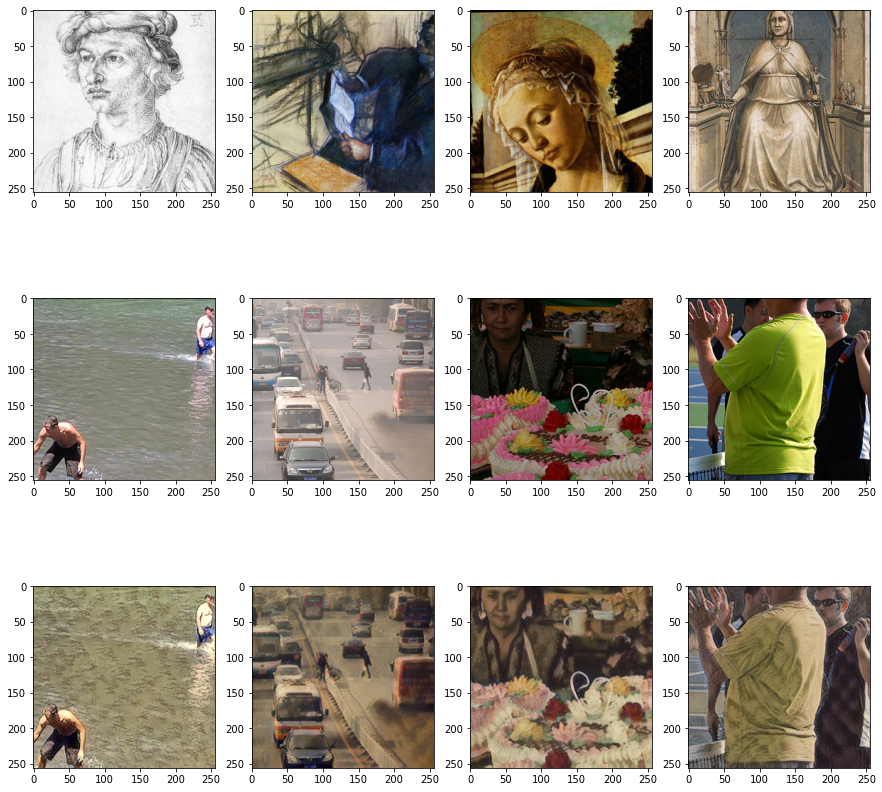

<Figure size 432x288 with 0 Axes>

In [23]:
clear_vram()
display_style_transfer(show=True)
plt.clf()

In [24]:
save_all()

wandb: Adding directory to artifact (/kaggle/working/models)... Done. 0.2s
